In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import csv
import re
import numpy as np
import pandas as pd
from collections import Counter
import pickle

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import randint, uniform
import math

In [ ]:
file_train = "/content/drive/MyDrive/TRAIN.csv"

players, actions_list = [], []
with open(file_train, "r", encoding="utf-8") as f:
    reader = csv.reader(f)
    for row in reader:
        # row[0] = player URL
        # row[1] = race (ignoré)
        # row[2:] = actions
        if len(row) < 2:
            continue
        players.append(row[0])
        actions_list.append(row[2:])  # on saute la race

df = pd.DataFrame({"player": players, "actions": actions_list})


In [ ]:
def remove_time_markers(seq):
    return [x for x in seq if not re.match(r'^t\d+$', x)]

df["actions_clean"] = df["actions"].apply(remove_time_markers)

def get_last_time(seq):
    tmax = 0
    for x in seq:
        m = re.match(r'^t(\d+)$', x)
        if m:
            val = int(m.group(1))
            if val>tmax:
                tmax = val
    return tmax

df["last_time"] = df["actions"].apply(get_last_time)

df["action_counter"] = df["actions_clean"].apply(Counter)

# 1) Filtrer les actions trop rares
all_actions = Counter()
for c in df["action_counter"]:
    all_actions.update(c.keys())

MIN_REPLAYS = 5
action_presence_count = Counter()
for a in all_actions:
    presence = df["action_counter"].apply(lambda x: a in x).sum()
    action_presence_count[a] = presence

filtered_actions = [a for (a, cnt) in action_presence_count.items() if cnt>=MIN_REPLAYS]

def to_freq_vector(counter_obj, actions_kept):
    total_count = sum(counter_obj.values())
    if total_count==0:
        return [0]*len(actions_kept)
    else:
        return [counter_obj.get(a,0)/total_count for a in actions_kept]

X_list = []
for c in df["action_counter"]:
    X_list.append(to_freq_vector(c, filtered_actions))
X_bag = pd.DataFrame(X_list, columns=filtered_actions)


In [ ]:
df["total_actions"] = df["action_counter"].apply(lambda c: sum(c.values()))
df["distinct_actions"] = df["action_counter"].apply(lambda c: len(c))
df["ratio_distinct"] = df.apply(lambda row:
    row["distinct_actions"]/row["total_actions"] if row["total_actions"]>0 else 0, axis=1)

def entropy_actions(c):
    tot = sum(c.values())
    if tot==0:
        return 0
    ent = 0
    for act, count in c.items():
        p = count/tot
        ent -= p*math.log2(p)
    return ent

df["entropy"] = df["action_counter"].apply(entropy_actions)

def compute_apm(total_actions, last_time):
    if last_time>0:
        return total_actions/(last_time/60)
    else:
        return 0

df["apm"] = df.apply(lambda row: compute_apm(row["total_actions"], row["last_time"]), axis=1)

X_misc = df[["total_actions","distinct_actions","ratio_distinct","entropy","apm"]]

# Concat bag-of-actions + features globales
X = pd.concat([X_bag, X_misc], axis=1)


In [ ]:
players_unique = df["player"].unique()
player_to_id = {p:i for i,p in enumerate(players_unique)}
id_to_player = {v:k for k,v in player_to_id.items()}
y = df["player"].map(player_to_id)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------
# F) RandomizedSearchCV
# -------------------------
param_dist = {
    "n_estimators": randint(50, 300),
    "max_depth": randint(10, 50),
    "min_samples_leaf": randint(1, 5),
    "max_features": ["sqrt", "log2", 0.3, 0.5]
}

rf_model = RandomForestClassifier(random_state=42)

from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring="accuracy",
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train)

print("Meilleurs paramètres trouvés :", random_search.best_params_)
print("Meilleur score (CV) :", random_search.best_score_)

best_rf = random_search.best_estimator_

# Évaluation sur la validation (hors CV)
y_val_pred = best_rf.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
print("Accuracy sur le set de validation :", val_acc)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Meilleurs paramètres trouvés : {'max_depth': 44, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 213}
Meilleur score (CV) : 0.9057762580039558
Accuracy sur le set de validation : 0.9018003273322422


In [ ]:
mappings = {
    "filtered_actions": filtered_actions,
    "player_to_id": player_to_id,
    "id_to_player": id_to_player,
    "X_columns": X.columns
}

with open("model_rf.pkl","wb") as f:
    pickle.dump(best_rf, f)

with open("mappings.pkl","wb") as f:
    pickle.dump(mappings, f)

print("Modèle sans race sauvegardé. Score CV ~", random_search.best_score_)
print("Score validation :", val_acc)


Modèle sans race sauvegardé. Score CV ~ 0.9057762580039558
Score validation : 0.9018003273322422


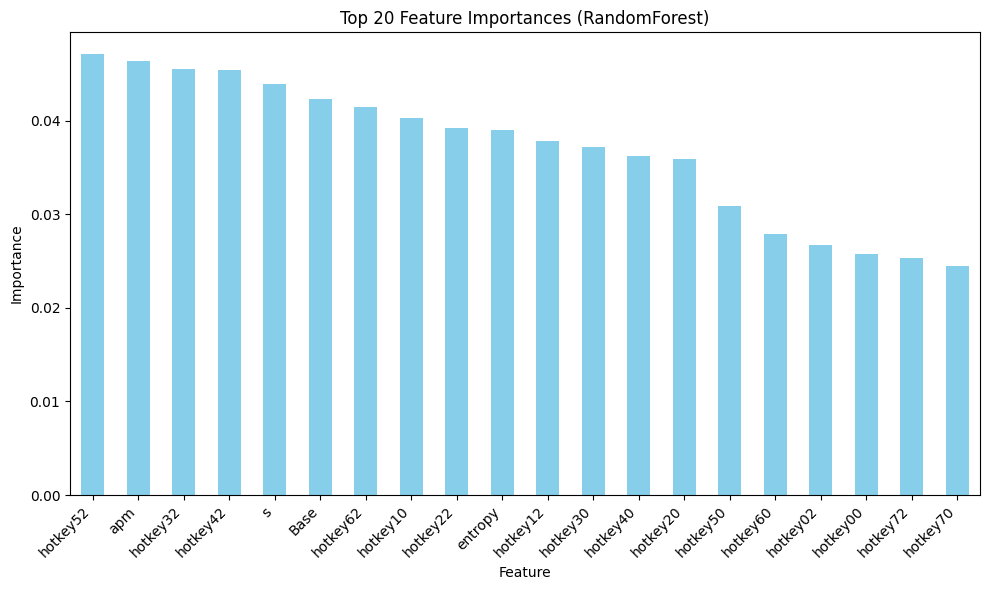

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Juste après :
# best_rf = random_search.best_estimator_

# 1) Récupérer les importances et les noms de features
importances = best_rf.feature_importances_      # array de longueur len(X.columns)
feature_names = X.columns                       # liste/Index des noms de colonnes

# 2) Convertir en Series pour manipuler facilement
feat_importances = pd.Series(importances, index=feature_names)

# 3) Trier par ordre décroissant
feat_importances_sorted = feat_importances.sort_values(ascending=False)

# 4) Afficher, par exemple, le top 20
top_n = 20
feat_importances_sorted.head(top_n).plot(kind='bar', figsize=(10,6), color='skyblue')
plt.title(f"Top {top_n} Feature Importances (RandomForest)")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# (Optionnel) Pour afficher toutes les colonnes, tu peux faire directement :
# feat_importances_sorted.plot(kind='bar', figsize=(12,6))


In [ ]:
import csv
import re
import math
import numpy as np
import pandas as pd
from collections import Counter
import pickle

from sklearn.ensemble import RandomForestClassifier

with open("model_rf.pkl","rb") as f:
    best_rf = pickle.load(f)
with open("mappings.pkl","rb") as f:
    saved = pickle.load(f)

filtered_actions = saved["filtered_actions"]
id_to_player = saved["id_to_player"]
X_columns = saved["X_columns"]

def remove_time_markers(seq):
    return [x for x in seq if not re.match(r'^t\d+$', x)]

def get_last_time(seq):
    tmax = 0
    for x in seq:
        m = re.match(r'^t(\d+)$', x)
        if m:
            val = int(m.group(1))
            if val>tmax:
                tmax = val
    return tmax

def to_freq_vector(counter_obj, actions_kept):
    total_count = sum(counter_obj.values())
    if total_count==0:
        return [0]*len(actions_kept)
    else:
        return [counter_obj.get(a,0)/total_count for a in actions_kept]

def entropy_actions(c):
    tot = sum(c.values())
    if tot==0:
        return 0
    ent = 0
    for act, count in c.items():
        p = count/tot
        ent -= p*math.log2(p)
    return ent

def compute_apm(total_actions, last_time):
    if last_time>0:
        return total_actions/(last_time/60)
    else:
        return 0

# Lire le TEST
file_test = '/content/drive/MyDrive/TEST.CSV'

actions_test = []
with open(file_test,"r",encoding="utf-8") as f:
    reader = csv.reader(f)
    for row in reader:
        if len(row)<1:
            continue
        # row[0] = race (on ignore)
        # row[1:] = actions
        actions_test.append(row[1:])

df_test = pd.DataFrame({"actions": actions_test})

df_test["actions_clean"] = df_test["actions"].apply(remove_time_markers)
df_test["last_time"] = df_test["actions"].apply(get_last_time)
df_test["action_counter"] = df_test["actions_clean"].apply(Counter)

# Bag-of-actions (fréquences)
X_list_test = []
for c in df_test["action_counter"]:
    X_list_test.append(to_freq_vector(c, filtered_actions))
X_test_bag = pd.DataFrame(X_list_test, columns=filtered_actions)

df_test["total_actions"] = df_test["action_counter"].apply(lambda c: sum(c.values()))
df_test["distinct_actions"] = df_test["action_counter"].apply(lambda c: len(c))
df_test["ratio_distinct"] = df_test.apply(
    lambda row: row["distinct_actions"]/row["total_actions"] if row["total_actions"]>0 else 0,
    axis=1
)
df_test["entropy"] = df_test["action_counter"].apply(entropy_actions)
df_test["apm"] = df_test.apply(
    lambda row: compute_apm(row["total_actions"], row["last_time"]),
    axis=1
)

X_test_misc = df_test[["total_actions","distinct_actions","ratio_distinct","entropy","apm"]]

# Concaténer
X_test_full = pd.concat([X_test_bag, X_test_misc], axis=1)
X_test_full = X_test_full.reindex(columns=X_columns, fill_value=0)

pred_ids = best_rf.predict(X_test_full)
pred_players = [id_to_player[i] for i in pred_ids]

submission = pd.DataFrame({
    "RowId": range(1, len(pred_players)+1),
    "prediction": pred_players
})
submission.to_csv("submission_norace.csv", index=False)
print("Fichier submission_norace.csv créé :", len(submission), "lignes.")


Fichier submission_norace.csv créé : 340 lignes.
